In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.layers import Input

PPG_file = '../../dataset/raw/PPG-BP dataset.xlsx'
data = pd.read_excel(PPG_file)

In [2]:
# Chuyển đổi cột 'Hypertension' thành
#0 nếu Normal, 1 nếu Stage 1, 2 nếu Stage 2, 3 nếu Pre
def convert_hypertension_status(status):
    if status == "Normal":
        return 0
    elif status == "Stage 1 hypertension":
        return 1
    elif status == "Stage 2 hypertension":
        return 2
    elif status == "Prehypertension":
        return 3
    else:
        return status
    
if data['Hypertension'].dtype == object:
    data['Hypertension'] = data['Hypertension'].apply(convert_hypertension_status)

#giữ nguyên dtype là object
data['Hypertension'] = data['Hypertension'].astype('int')

In [3]:
data['Hypertension'].value_counts()

Hypertension
3    85
0    80
1    34
2    20
Name: count, dtype: int64

In [4]:
# Chọn features
# selected_features_8 = ['Sex(M/F)', 'Age(year)', 'Height(cm)', 'Weight(kg)',
#                        'Systolic Blood Pressure(mmHg)', 'Diastolic Blood Pressure(mmHg)',
#                        'Heart Rate(b/m)', 'BMI(kg/m^2)', 'Hypertension']

selected_features_7 = ['Age(year)', 'Height(cm)', 'Weight(kg)',
                       'Systolic Blood Pressure(mmHg)', 'Diastolic Blood Pressure(mmHg)',
                       'Heart Rate(b/m)', 'BMI(kg/m^2)', 'Hypertension']


# data với features đã chọn
# data_selected_8 = data[selected_features_8]
data_selected_7 = data[selected_features_7].copy()
data_selected_7['Hypertension'] = data_selected_7['Hypertension'].astype('int')


# In ra để kiểm tra
data_selected_7.head()

,Age(year),Height(cm),Weight(kg),Systolic Blood Pressure(mmHg),Diastolic Blood Pressure(mmHg),Heart Rate(b/m),BMI(kg/m^2),Hypertension
0,45,152,63,161,89,97,27.268006,2
1,50,157,50,160,93,76,20.284799,2
2,47,150,47,101,71,79,20.888889,0
3,45,172,65,136,93,87,21.971336,3
4,46,155,65,123,73,73,27.055151,3


# MLP

In [5]:
data_selected_7['Hypertension'] = data_selected_7['Hypertension'].astype('int')

# Chia dữ liệu thành X (features) và y (target)
X = data_selected_7.drop(columns=['Hypertension'])
y = data_selected_7['Hypertension']

# Chia dữ liệu thành tập huấn luyện và kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [63]:
def MLP_model(optimizer='adam', dropout_rate=0.4, activation='relu', neurons=64, l2_reg=0.01):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))
    model.add(Dense(neurons, activation=activation, kernel_regularizer=l2(l2_reg)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons // 2, activation=activation, kernel_regularizer=l2(l2_reg)))
    model.add(Dense(4, activation='softmax'))
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
param_dist_1 = {
    'model__optimizer': ['adam', 'sgd'],
    'model__dropout_rate': [0.3, 0.4, 0.5],
    'model__activation': ['relu', 'tanh'],
    'model__neurons': [32, 64],
    'batch_size': [32, 64],
    'epochs': [50, 100]
}

# RandomizedSearchCV để tìm hyperparameters tốt nhất (Lần 1)
random_search_1 = RandomizedSearchCV(estimator=model, param_distributions=param_dist_1, n_iter=10, cv=3, verbose=2, n_jobs=-1)
random_search_1.fit(X_train, y_train)

# In ra các hyperparameter tốt nhất sau lần 1
best_params_1 = random_search_1.best_params_
print("Best Hyperparameters after 1st tuning:", best_params_1)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Hyperparameters after 1st tuning: {'model__optimizer': 'adam', 'model__neurons': 64, 'model__dropout_rate': 0.5, 'model__activation': 'tanh', 'epochs': 100, 'batch_size': 32}


In [ ]:
param_dist_2 = {
    'model__optimizer': [best_params_1['model__optimizer']],
    'model__dropout_rate': [max(0.25, best_params_1['model__dropout_rate'] - 0.05),
                            best_params_1['model__dropout_rate'], 
                            min(0.55, best_params_1['model__dropout_rate'] + 0.05)],
    'model__activation': [best_params_1['model__activation']],
    'model__neurons': [max(16, best_params_1['model__neurons'] - 16), 
                       best_params_1['model__neurons'], 
                       best_params_1['model__neurons'] + 16],
    'batch_size': [best_params_1['batch_size'], 
                   min(128, best_params_1['batch_size'] + 16)],
    'epochs': [max(30, best_params_1['epochs'] - 20), 
               best_params_1['epochs'], 
               min(150, best_params_1['epochs'] + 20)]
} 

# RandomizedSearchCV để tìm hyperparameters tốt nhất (Lần 2)
random_search_2 = RandomizedSearchCV(estimator=model, param_distributions=param_dist_2, n_iter=10, cv=3, verbose=2, n_jobs=-1)
random_search_2.fit(X_train, y_train)

# In ra các hyperparameter tốt nhất sau lần 2
best_params_2 = random_search_2.best_params_
print("Best Hyperparameters after 2nd tuning:", best_params_2)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Hyperparameters after 2nd tuning: {'model__optimizer': 'adam', 'model__neurons': 80, 'model__dropout_rate': 0.45, 'model__activation': 'tanh', 'epochs': 120, 'batch_size': 32}


Epoch 1/120
5/5 - 1s - 276ms/step - accuracy: 0.3357 - loss: 2.0324 - val_accuracy: 0.5143 - val_loss: 1.9007
Epoch 2/120
5/5 - 0s - 10ms/step - accuracy: 0.4786 - loss: 1.8523 - val_accuracy: 0.6000 - val_loss: 1.7748
Epoch 3/120
5/5 - 0s - 9ms/step - accuracy: 0.5357 - loss: 1.7448 - val_accuracy: 0.5714 - val_loss: 1.7004
Epoch 4/120
5/5 - 0s - 9ms/step - accuracy: 0.6429 - loss: 1.6466 - val_accuracy: 0.5143 - val_loss: 1.6485
Epoch 5/120
5/5 - 0s - 9ms/step - accuracy: 0.5929 - loss: 1.5797 - val_accuracy: 0.5143 - val_loss: 1.6072
Epoch 6/120
5/5 - 0s - 9ms/step - accuracy: 0.6500 - loss: 1.5031 - val_accuracy: 0.4857 - val_loss: 1.5782
Epoch 7/120
5/5 - 0s - 9ms/step - accuracy: 0.6643 - loss: 1.4613 - val_accuracy: 0.4857 - val_loss: 1.5514
Epoch 8/120
5/5 - 0s - 9ms/step - accuracy: 0.6571 - loss: 1.4318 - val_accuracy: 0.5429 - val_loss: 1.5189
Epoch 9/120
5/5 - 0s - 12ms/step - accuracy: 0.6786 - loss: 1.4000 - val_accuracy: 0.5714 - val_loss: 1.4896
Epoch 10/120
5/5 - 0s - 

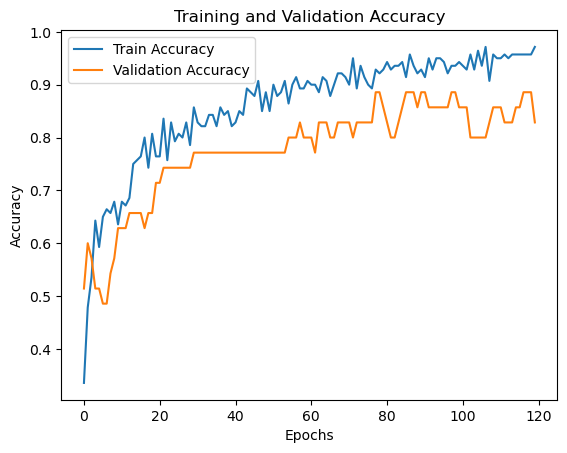

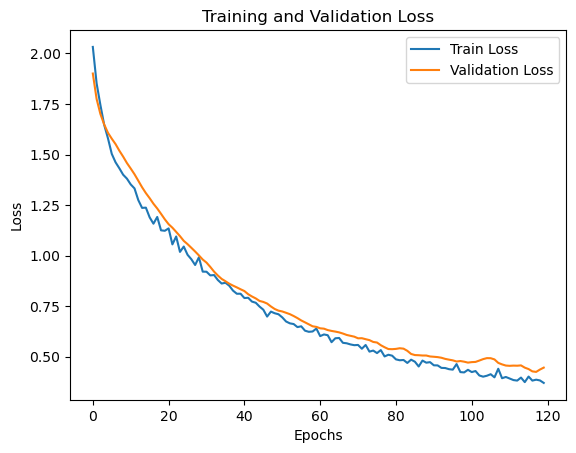

In [ ]:
from tensorflow.keras.regularizers import l2

final_model = MLP_model(optimizer=best_params_2['model__optimizer'],
                        dropout_rate=best_params_2['model__dropout_rate'],
                        activation=best_params_2['model__activation'],
                        neurons=best_params_2['model__neurons'])

# Early Stopping để tránh overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Huấn luyện mô hình cuối cùng
history = final_model.fit(X_train, y_train,
                          validation_split=0.2,
                          epochs=best_params_2['epochs'],
                          batch_size=best_params_2['batch_size'],
                          callbacks=[early_stopping],
                          verbose=2)

test_loss, test_accuracy = final_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.2f} ,Test Loss: {test_loss:.2f}")

In [1]:
# Vẽ biểu đồ quá trình huấn luyện
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.savefig('../fig/MLP_accuracy.png')
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.savefig('../fig/MLP_lost.png')
plt.show()

NameError: name 'plt' is not defined

In [111]:
from sklearn.metrics import classification_report

y_pred = np.argmax(final_model.predict(X_test), axis=1)
print(classification_report(y_test, y_pred, target_names=['Normal', 'Stage 1', 'Stage 2', 'Prehypertension']))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
                 precision    recall  f1-score   support

         Normal       1.00      1.00      1.00        16
        Stage 1       1.00      0.86      0.92         7
        Stage 2       0.80      1.00      0.89         4
Prehypertension       1.00      1.00      1.00        17

       accuracy                           0.98        44
      macro avg       0.95      0.96      0.95        44
   weighted avg       0.98      0.98      0.98        44



In [110]:
save_models = "../save_models"
model_path = os.path.join(save_models, "MLP_model.keras")

# Lưu mô hình dưới định dạng .keras
final_model.save(model_path)
print(f"Model saved at: {model_path}")
print(f"Test Accuracy: {test_accuracy:.2f} ,Test Loss: {test_loss:.2f}")

Model saved at: ../save_models\MLP_model.keras
Test Accuracy: 0.98 ,Test Loss: 0.37


# MLP .txt file

# CNN + LSTM

In [107]:
PPG_SQI_file = '../PPG_SQI_Results.csv'
folder_normalized = '../0_subjectSQI_normalized'
labels_df = pd.read_csv(PPG_SQI_file)

In [108]:
def load_ppg_data(folder_normalized, PPG_SQI_file):
    labels_df = pd.read_csv(PPG_SQI_file)
    labels_df['file_name'] = labels_df['Subject_ID'].astype(str) + "_" + labels_df['Max SQI Signal'].astype(int).astype(str) + ".txt"
    
    # Định nghĩa mapping nhãn
    label_mapping = {
        'Normal': 0,
        'Stage 1 hypertension': 1,
        'Stage 2 hypertension': 2,
        'Prehypertension': 3
    }
    labels_df['Label'] = labels_df['Label'].map(label_mapping)
    
    signals = []
    labels = []
    processed_files = []

    for file_name in sorted(os.listdir(folder_normalized)):
        if file_name.endswith('.txt'):
            file_path = os.path.join(folder_normalized, file_name)
            try:
                with open(file_path, 'r') as f:
                    signal = np.array([float(line.strip()) for line in f])
                if file_name in labels_df['file_name'].values:
                    label = labels_df.loc[labels_df['file_name'] == file_name, 'Label'].values[0]
                    signals.append(signal)
                    labels.append(label)
                    processed_files.append(file_name)
            except Exception as e:
                print(f"Lỗi khi đọc file {file_name}: {e}")

    signals = np.array(signals)
    labels = np.array(labels)
    return signals, labels, label_mapping

In [109]:
signals, labels, label_mapping = load_ppg_data(folder_normalized, PPG_SQI_file)

# Kiểm tra dữ liệu
print("Hình dạng tín hiệu (signals):", signals.shape)
print("Hình dạng nhãn (labels):", labels.shape)
print("Mapping nhãn:", label_mapping)

# Hiển thị thông tin chi tiết của 10 tín hiệu đầu tiên
for i in range(min(10, len(labels))):
    file_name = processed_files[i]  # Lấy tên file từ danh sách đã xử lý
    label_original = [k for k, v in label_mapping.items() if v == labels[i]][0]  # Tra nhãn gốc từ mapping
    print(f"File {i+1}: File name: {file_name}, Signal shape: {signals[i].shape}, "
          f"Label (Mapped): {labels[i]}, Label (Original): {label_original}")

Hình dạng tín hiệu (signals): (219, 2100)
Hình dạng nhãn (labels): (219,)
Mapping nhãn: {'Normal': 0, 'Stage 1 hypertension': 1, 'Stage 2 hypertension': 2, 'Prehypertension': 3}
File 1: File name: 100_2.txt, Signal shape: (2100,), Label (Mapped): 1, Label (Original): Stage 1 hypertension
File 2: File name: 103_2.txt, Signal shape: (2100,), Label (Mapped): 3, Label (Original): Prehypertension
File 3: File name: 104_1.txt, Signal shape: (2100,), Label (Mapped): 3, Label (Original): Prehypertension
File 4: File name: 105_3.txt, Signal shape: (2100,), Label (Mapped): 3, Label (Original): Prehypertension
File 5: File name: 106_3.txt, Signal shape: (2100,), Label (Mapped): 3, Label (Original): Prehypertension
File 6: File name: 107_2.txt, Signal shape: (2100,), Label (Mapped): 0, Label (Original): Normal
File 7: File name: 108_1.txt, Signal shape: (2100,), Label (Mapped): 3, Label (Original): Prehypertension
File 8: File name: 10_1.txt, Signal shape: (2100,), Label (Mapped): 3, Label (Origin

In [110]:
X_train, X_test, y_train, y_test = train_test_split(signals, labels, test_size=0.2, random_state=42, stratify=labels)
y_train = to_categorical(y_train, num_classes=4)
y_test = to_categorical(y_test, num_classes=4)

# Reshape dữ liệu để phù hợp với CNN/LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [111]:
def build_model(hp):
    model = Sequential()

    # Lớp CNN
    model.add(Conv1D(
        filters=hp.Choice('filters', [32, 64, 128]),
        kernel_size=hp.Choice('kernel_size', [3, 5, 7]),
        activation='relu',
        input_shape=(X_train.shape[1], 1)
    ))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(hp.Choice('dropout_rate_cnn', [0.2, 0.3, 0.5])))

    # Lớp LSTM
    model.add(LSTM(hp.Choice('lstm_units', [32, 64, 128]), return_sequences=True))
    model.add(Dropout(hp.Choice('dropout_rate_lstm', [0.2, 0.3, 0.5])))
    model.add(LSTM(hp.Choice('lstm_units', [32, 64, 128])))

    # Lớp Dense
    model.add(Dense(hp.Choice('dense_units', [64, 128, 256]), activation='relu'))
    model.add(Dropout(hp.Choice('dropout_rate_dense', [0.2, 0.3, 0.5])))
    model.add(Dense(4, activation='softmax'))

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [112]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=2,
    directory='hyperparameter_tuning',
    project_name='lstm_cnn'
)

# Tìm kiếm tham số tối ưu
tuner.search(X_train, y_train, epochs=20, validation_split=0.2, batch_size=32)

Trial 9 Complete [00h 01m 37s]
val_accuracy: 0.37142857909202576

Best val_accuracy So Far: 0.5142857432365417
Total elapsed time: 00h 17m 01s

Search: Running Trial #10

Value             |Best Value So Far |Hyperparameter
32                |32                |filters
7                 |7                 |kernel_size
0.5               |0.5               |dropout_rate_cnn
64                |128               |lstm_units
0.2               |0.3               |dropout_rate_lstm
64                |128               |dense_units
0.3               |0.2               |dropout_rate_dense

Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 735ms/step - accuracy: 0.3207 - loss: 1.3752 - val_accuracy: 0.2857 - val_loss: 1.3853
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 449ms/step - accuracy: 0.3701 - loss: 1.3300 - val_accuracy: 0.2857 - val_loss: 1.3666
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 434ms/step - accuracy: 0.4115 - loss: 1.2947 - val_accuracy: 0.2857 - val_loss: 1.3479
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━

KeyboardInterrupt: 

In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]

# Huấn luyện mô hình tốt nhất
history = best_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=32
)

test_loss, test_accuracy = best_model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Lưu mô hình tốt nhất
best_model.save("..save_models/lstm_cnn_hypertension_model.keras")